# בנה מודל סיווג: מטבחים אסייתיים והודיים טעימים


## מסווגי מטבחים 1

בשיעור הזה, נחקור מגוון מסווגים כדי *לחזות מטבח לאומי מסוים בהתבסס על קבוצת מרכיבים.* תוך כדי כך, נלמד יותר על הדרכים שבהן ניתן להשתמש באלגוריתמים למשימות סיווג.

### [**שאלון לפני השיעור**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **הכנה**

השיעור הזה מתבסס על [השיעור הקודם שלנו](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) שבו:

-   עשינו היכרות עדינה עם סיווגים באמצעות מערך נתונים על כל המטבחים המדהימים של אסיה והודו 😋.

-   חקרנו כמה [פועלי dplyr](https://dplyr.tidyverse.org/) כדי להכין ולנקות את הנתונים שלנו.

-   יצרנו ויזואליזציות יפות באמצעות ggplot2.

-   הדגמנו כיצד להתמודד עם נתונים לא מאוזנים על ידי עיבודם באמצעות [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   הדגמנו כיצד `prep` ו-`bake` את המתכון שלנו כדי לוודא שהוא יעבוד כפי שמצופה.

#### **דרישות מקדימות**

לשיעור הזה, נצטרך את החבילות הבאות כדי לנקות, להכין וליצור ויזואליזציות לנתונים שלנו:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) הוא [אוסף של חבילות R](https://www.tidyverse.org/packages) שנועד להפוך את מדע הנתונים למהיר, קל ומהנה יותר!

-   `tidymodels`: [מסגרת tidymodels](https://www.tidymodels.org/) היא [אוסף של חבילות](https://www.tidymodels.org/packages/) למידול ולמידת מכונה.

-   `themis`: [חבילת themis](https://themis.tidymodels.org/) מספקת שלבים נוספים במתכונים להתמודדות עם נתונים לא מאוזנים.

-   `nnet`: [חבילת nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) מספקת פונקציות להערכת רשתות עצביות קדמיות עם שכבה נסתרת אחת, ולמודלים של רגרסיה לוגיסטית רב-קטגורית.

ניתן להתקין אותן כך:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

לחילופין, הסקריפט הבא בודק אם יש לך את החבילות הנדרשות להשלמת המודול הזה ומתקין אותן עבורך במקרה שהן חסרות.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. פיצול הנתונים למערכי אימון ובדיקה.

נתחיל בבחירת כמה שלבים מהשיעור הקודם.

### הסרת המרכיבים הנפוצים ביותר שיוצרים בלבול בין מטבחים שונים, באמצעות `dplyr::select()`.

כולם אוהבים אורז, שום וג'ינג'ר!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

מעולה! עכשיו, הגיע הזמן לחלק את הנתונים כך ש-70% מהנתונים יוקצו לאימון ו-30% לבדיקות. בנוסף, נשתמש בטכניקת `stratification` בעת חלוקת הנתונים כדי `לשמור על היחס של כל סוג מטבח` במערכי הנתונים של האימון והאימות.

[rsample](https://rsample.tidymodels.org/), חבילה ב-Tidymodels, מספקת תשתית לחלוקה יעילה של נתונים ולדגימה חוזרת:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. התמודדות עם נתונים לא מאוזנים

כפי שייתכן ששמתם לב במערך הנתונים המקורי וגם במערך האימון שלנו, יש חלוקה לא שווה במספר סוגי המטבחים. מטבח קוריאני מופיע *כמעט* פי 3 ממטבח תאילנדי. נתונים לא מאוזנים משפיעים לעיתים קרובות באופן שלילי על ביצועי המודל. רבים מהמודלים עובדים בצורה הטובה ביותר כאשר מספר התצפיות שווה, ולכן מתקשים להתמודד עם נתונים לא מאוזנים.

ישנן שתי דרכים עיקריות להתמודד עם מערכי נתונים לא מאוזנים:

-   הוספת תצפיות לקבוצה המיעוט: `דגימה יתרה` לדוגמה, שימוש באלגוריתם SMOTE שמייצר באופן סינתטי דוגמאות חדשות לקבוצה המיעוט באמצעות שכנים קרובים של המקרים הללו.

-   הסרת תצפיות מקבוצת הרוב: `דגימה חסרה`

בשיעור הקודם, הדגמנו כיצד להתמודד עם מערכי נתונים לא מאוזנים באמצעות `מתכון`. מתכון ניתן לחשוב עליו כעל תוכנית פעולה שמתארת אילו שלבים יש ליישם על מערך נתונים כדי להכין אותו לניתוח נתונים. במקרה שלנו, אנו רוצים להשיג חלוקה שווה במספר סוגי המטבחים עבור `מערך האימון` שלנו. בואו נתחיל.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

אתם יכולים כמובן לאשר (באמצעות prep+bake) שהמתכון יעבוד כפי שאתם מצפים - כל התוויות המטבח מכילות `559` תצפיות.

מכיוון שנשתמש במתכון הזה כמעבד מקדים למידול, `workflow()` יבצע את כל ההכנה והאפייה עבורנו, כך שלא נצטרך להעריך את המתכון באופן ידני.

עכשיו אנחנו מוכנים לאמן מודל 👩‍💻👨‍💻!

## 3. בחירת הסיווג שלכם

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>יצירה מאת @allison_horst</figcaption>


עכשיו אנחנו צריכים להחליט איזה אלגוריתם להשתמש למשימה 🤔.

ב-Tidymodels, [`חבילת parsnip`](https://parsnip.tidymodels.org/index.html) מספקת ממשק עקבי לעבודה עם מודלים במנועים שונים (חבילות). אנא עיינו בתיעוד של parsnip כדי לחקור [סוגי מודלים ומנועים](https://www.tidymodels.org/find/parsnip/#models) ואת [הארגומנטים של המודלים](https://www.tidymodels.org/find/parsnip/#model-args) המתאימים להם. המגוון יכול להיות די מבלבל במבט ראשון. לדוגמה, השיטות הבאות כולן כוללות טכניקות סיווג:

-   מודלים מבוססי חוקים של C5.0

-   מודלים גמישים להבחנה

-   מודלים ליניאריים להבחנה

-   מודלים להבחנה רגולרית

-   מודלים של רגרסיה לוגיסטית

-   מודלים של רגרסיה מולטינומיאלית

-   מודלים של נאיב ביי

-   מכונות וקטור תמיכה

-   שכנים קרובים

-   עצי החלטה

-   שיטות אנסמבל

-   רשתות נוירונים

הרשימה ממשיכה!

### **איזה מסווג לבחור?**

אז, איזה מסווג כדאי לבחור? לעיתים, מעבר על כמה מהם וחיפוש אחר תוצאה טובה זו דרך לבדוק.

> AutoML פותר את הבעיה הזו בצורה יעילה על ידי ביצוע ההשוואות בענן, ומאפשר לך לבחור את האלגוריתם הטוב ביותר עבור הנתונים שלך. נסו זאת [כאן](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

בנוסף, הבחירה במסווג תלויה בבעיה שלנו. לדוגמה, כאשר התוצאה יכולה להיות מסווגת ל`יותר משתי קטגוריות`, כמו במקרה שלנו, עליך להשתמש ב`אלגוריתם סיווג רב-קטגורי` במקום `סיווג בינארי.`

### **גישה טובה יותר**

גישה טובה יותר מאשר לנחש באופן אקראי היא לעקוב אחר הרעיונות בדף העזר להורדה [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). כאן, אנו מגלים שבמקרה של הבעיה הרב-קטגורית שלנו, יש לנו כמה אפשרויות:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>קטע מדף העזר של אלגוריתמים של Microsoft, המתאר אפשרויות סיווג רב-קטגוריות</figcaption>


### **הסקה**

בואו ננסה להבין את הגישות האפשריות בהתחשב במגבלות שלנו:

-   **רשתות נוירונים עמוקות כבדות מדי**. בהתחשב בכך שיש לנו מערך נתונים נקי אך מינימלי, ובכך שאנו מבצעים את האימון באופן מקומי באמצעות מחברות, רשתות נוירונים עמוקות כבדות מדי למשימה זו.

-   **אין שימוש בסיווג דו-מחלקתי**. איננו משתמשים בסיווג דו-מחלקתי, ולכן גישה של "אחד מול כולם" אינה רלוונטית.

-   **עץ החלטה או רגרסיה לוגיסטית עשויים להתאים**. עץ החלטה עשוי להתאים, או לחלופין רגרסיה לוגיסטית רב-מחלקתית/רב-נומינלית עבור נתונים רב-מחלקתיים.

-   **עצים מואצים רב-מחלקתיים פותרים בעיה שונה**. עץ החלטה מואץ רב-מחלקתי מתאים יותר למשימות לא פרמטריות, לדוגמה משימות שמטרתן לבנות דירוגים, ולכן אינו שימושי עבורנו.

בנוסף, בדרך כלל לפני שניגשים למודלים מורכבים יותר של למידת מכונה, כמו שיטות אנסמבל, כדאי להתחיל עם המודל הפשוט ביותר כדי לקבל מושג על מה שקורה. לכן, בשיעור זה נתחיל עם מודל של `רגרסיה רב-נומינלית`.

> רגרסיה לוגיסטית היא טכניקה המשמשת כאשר משתנה התוצאה הוא קטגוריאלי (או נומינלי). ברגרסיה לוגיסטית בינארית מספר משתני התוצאה הוא שניים, בעוד שברגרסיה לוגיסטית רב-נומינלית מספר משתני התוצאה הוא יותר משניים. ראו [שיטות רגרסיה מתקדמות](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) לקריאה נוספת.

## 4. אימון והערכת מודל רגרסיה לוגיסטית רב-נומינלית

ב-Tidymodels, הפונקציה `parsnip::multinom_reg()` מגדירה מודל המשתמש במנבאים ליניאריים כדי לחזות נתונים רב-מחלקתיים באמצעות התפלגות רב-נומינלית. ראו `?multinom_reg()` כדי ללמוד על הדרכים/המנועים השונים שניתן להשתמש בהם כדי להתאים מודל זה.

בדוגמה זו, נתאים מודל רגרסיה רב-נומינלית באמצעות מנוע ברירת המחדל [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> בחרתי ערך עבור `penalty` באופן די אקראי. יש דרכים טובות יותר לבחור ערך זה, כמו שימוש ב-`resampling` וב-`tuning` של המודל, עליהן נדון בהמשך.
>
> ראו [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) אם תרצו ללמוד עוד על כוונון היפר-פרמטרים של מודלים.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


עבודה נהדרת 🥳! עכשיו כשיש לנו מתכון ומפרט מודל, אנחנו צריכים למצוא דרך לאגד אותם יחד לאובייקט שיבצע תחילה עיבוד מקדים לנתונים, לאחר מכן יתאים את המודל לנתונים שעברו עיבוד מקדים, וגם יאפשר פעילויות עיבוד לאחרי. ב-Tidymodels, האובייקט הנוח הזה נקרא [`workflow`](https://workflows.tidymodels.org/) והוא מחזיק בצורה נוחה את רכיבי המידול שלך! זה מה שהיינו קוראים לו *pipelines* ב-*Python*.

אז בואו נאגד הכל לתוך workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


תהליכי עבודה 👌👌! ניתן להתאים **`workflow()`** בצורה דומה מאוד לאופן שבו ניתן להתאים מודל. אז, הגיע הזמן לאמן מודל!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

הפלט מציג את המקדמים שהמודל למד במהלך האימון.

### הערכת המודל המאומן

זה הזמן לראות איך המודל ביצע 📏 על ידי הערכתו על קבוצת בדיקה! נתחיל בכך שנבצע תחזיות על קבוצת הבדיקה.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

עבודה נהדרת! ב-Tidymodels, ניתן להעריך את ביצועי המודל באמצעות [yardstick](https://yardstick.tidymodels.org/) - חבילה המשמשת למדידת האפקטיביות של מודלים באמצעות מדדי ביצועים. כפי שעשינו בשיעור הרגרסיה הלוגיסטית שלנו, בואו נתחיל בחישוב מטריצת בלבול.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

כאשר מתמודדים עם מספר מחלקות, זה בדרך כלל יותר אינטואיטיבי לדמיין זאת כמפת חום, כמו זו:


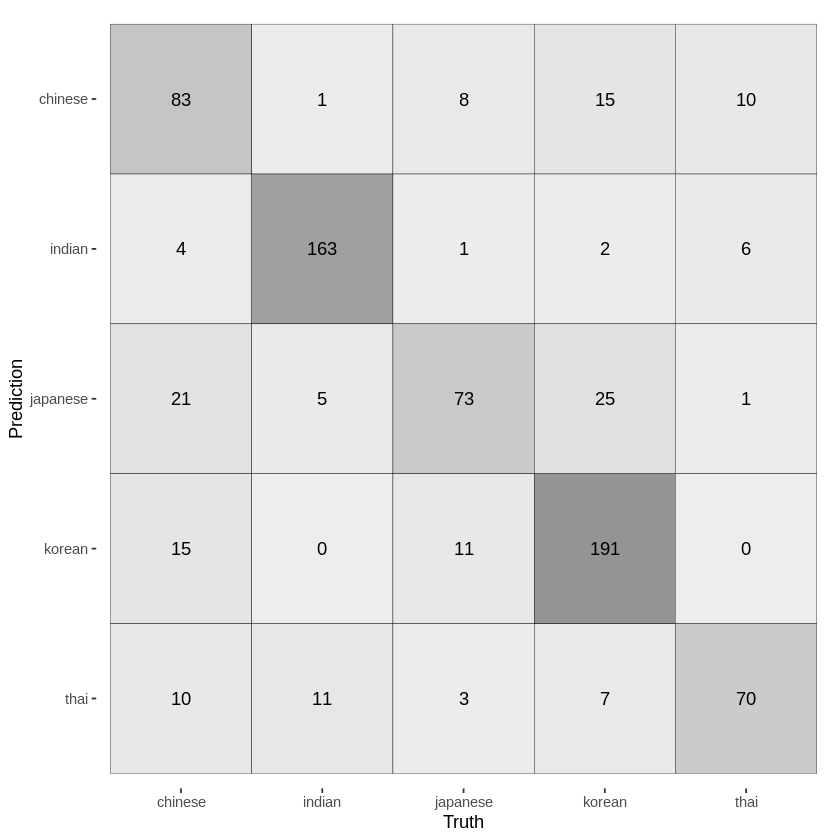

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

הריבועים הכהים יותר בתרשים מטריצת הבלבול מצביעים על מספרים גבוהים של מקרים, ואתם יכולים לקוות לראות קו אלכסוני של ריבועים כהים שמצביע על מקרים שבהם התווית החזויה והתווית האמיתית זהות.

בואו עכשיו נחשב סטטיסטיקות סיכום עבור מטריצת הבלבול.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

אם נצמצם למדדים מסוימים כמו דיוק, רגישות, ppv, אנחנו לא במצב רע להתחלה 🥳!

## 4. חקירה מעמיקה

בואו נשאל שאלה עדינה: אילו קריטריונים משמשים להחליט על סוג המטבח שנבחר כתוצאה החזויה?

ובכן, אלגוריתמים של למידת מכונה סטטיסטית, כמו רגרסיה לוגיסטית, מבוססים על `הסתברות`; כלומר, מה שבפועל מנבא מסווג הוא התפלגות הסתברותית על פני סט של תוצאות אפשריות. הקטגוריה עם ההסתברות הגבוהה ביותר נבחרת אז כתוצאה הסבירה ביותר עבור התצפיות הנתונות.

בואו נראה את זה בפעולה על ידי ביצוע גם תחזיות קטגוריה חד-משמעיות וגם הסתברויות.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ האם תוכל להסביר מדוע המודל בטוח למדי שההתבוננות הראשונה היא תאית?

## **🚀אתגר**

בשיעור הזה השתמשת בנתונים הנקיים שלך כדי לבנות מודל למידת מכונה שיכול לחזות מטבח לאומי בהתבסס על סדרת מרכיבים. הקדש זמן לקרוא על [אפשרויות רבות](https://www.tidymodels.org/find/parsnip/#models) ש-Tidymodels מספקת לסיווג נתונים ועל [דרכים נוספות](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) להתאים רגרסיה מולטינומית.

#### תודה ל:

[`אליסון הורסט`](https://twitter.com/allison_horst/) על יצירת האיורים המדהימים שהופכים את R לנגישה ומזמינה יותר. ניתן למצוא עוד איורים בגלריה שלה [כאן](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[קסי ברוויו](https://www.twitter.com/cassieview) ו[ג'ן לופר](https://www.twitter.com/jenlooper) על יצירת הגרסה המקורית של המודול הזה בפייתון ♥️

<br>
הייתי מוסיף כמה בדיחות, אבל אני לא מבין משחקי מילים על אוכל 😅.

<br>

למידה מהנה,

[אריק](https://twitter.com/ericntay), שגריר סטודנטים של Microsoft Learn Gold.



---

**כתב ויתור**:  
מסמך זה תורגם באמצעות שירות תרגום מבוסס בינה מלאכותית [Co-op Translator](https://github.com/Azure/co-op-translator). למרות שאנו שואפים לדיוק, יש לקחת בחשבון שתרגומים אוטומטיים עשויים להכיל שגיאות או אי דיוקים. המסמך המקורי בשפתו המקורית צריך להיחשב כמקור סמכותי. עבור מידע קריטי, מומלץ להשתמש בתרגום מקצועי על ידי אדם. איננו נושאים באחריות לאי הבנות או לפרשנויות שגויות הנובעות משימוש בתרגום זה.
